# Project 9 - Pricing Mortage Backed Securities

**Name:** Bowen Chen

**Section:** 1

**Date:** March 14, 2018 

In [1]:
# python set up
import matplotlib.pyplot as plt
from numpy import*
import pandas as pd
from scipy.stats import * 
from scipy.optimize import newton
set_printoptions(threshold=float('inf'), linewidth= 200, suppress = True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Problem Statement

Consider a 30-year MBS with a fixed WAC = 8% (monthly cash flows starting in January of this year). The Notional Amount of the Loan is \$100,000. Use the CIR model of interest rates $dr_t = \kappa (\bar{r}− r_t)dt + \sigma \sqrt{r_t}dW_t$ with $r_0$ = 0.078,$\kappa$ = 0.6, $\bar{r}$ = 0.08, $\sigma$ = 0.12. 

**1.** Consider the Numerix Prepayment Model

**(a)** Compute the price of the MBS using this model for prepayments. The code should be generic: the user is prompted for inputs and the program runs and gives the output. 

**Solution:**

**interest rate**

Build the function that models interest rate under CIR

In [2]:
def CIR(r0, sd, k, r_mean, total_years, paths):
    random.seed(7)
    dt = 1/120
    steps = int(total_years/dt)
    rt = zeros((paths, steps + 1))
    rt[:, 0] = r0
    
    # use full truncation method for every interest rate that drops below 0
    for i in range(1, steps):
        rt[:,i] = (maximum(rt[:,i-1], 0) + k*(r_mean - maximum(rt[:,i-1], 0)) *dt 
                    + sd* sqrt(maximum(rt[:,i-1], 0))* sqrt(dt)*random.normal(0, 1, paths))
    return rt

**10-year spot rate**

Calculate 10 year zero coupon bond price, use the explicit formula

In [3]:
def Zero10Yr(rt, r_mean, sd, k, T, t):
    
    h1 = sqrt(k**2 + 2*sd**2)
    h2 = (k + h1)/2
    h3 = (2*k*r_mean)/sd**2
    
    A = ((h1 * exp(h2*(T - t)))/(h2 * (exp(h1*(T - t)) - 1) + h1))**h3
    B = (exp(h1*(T - t)) - 1)/(h2 * (exp(h1*(T - t)) - 1) + h1)
    
    return A*exp(-B*rt)

Find 10 year spot rate, using the CIR interest rate at time t as the starting point, $r_{t - 1}$ could be found as

$r_{t - 1}(T)^i = \frac{1}{T}ln(P_{t-1}^i)$

In [4]:
def spotRate_10yr(r0, sd, k, r_mean, total_years, paths):
   
    ru = CIR(r0, sd, k, r_mean, total_years, paths)
    zeros10yr = array(list(map(lambda rt: Zero10Yr(rt, r_mean, sd, k, 10, 0), ru)))
    spot_rate = -1/10*log(zeros10yr)
    
    # choose time index that corresponds to the monthly payment
    pay_time = arange(1, total_years*12 + 1) * 10 - 1

    return spot_rate[:, pay_time]

**prepayment model**

$$P_0 = E^*\bigg(\sum_{t = 1}^N PV(CF_t) \bigg) = E^*\bigg(\sum_{t = 1}^N d_t \cdot c_t\bigg)$$

To find $P_0$, we need to find the discount factor $d_t$ and $c_t$

**discount factors**

$d_t = exp(-\int_{0}^t r_u du) $

In [5]:
def discount_factor(r0, sd, k, r_mean, total_years, paths):
    dt = 1/120
    ru = CIR(r0, sd, k, r_mean, total_years, paths)
    df = exp(-cumsum(ru*dt , axis = 1))
    # choose time index that corresponds to the monthly payment
    pay_time = arange(1, total_years*12 + 1) * 10 - 1
    
    return df[:, pay_time]

**cash flow at time t**

$c_t = MP_t + PP_t$, where

$MP_t$ = monthly scheduled payment

$PP_t$ = prepayment 

In [6]:
def cash_flow_t(t, total_years, PV_previous, r, N, CPRt):
    
    # Find schedule total payment
    MPt = (PV_previous*r)/(1 - (1 + r)**(-N + (t - 1)))
    
    # find schedule principal payment, SPPt
    SPPt = PV_previous*r*(1/(1 - (1 + r)**(-N + (t - 1))) -  1)
    
    # find prepayment amount, PPt
    PPt = (PV_previous - SPPt)*(1 - (1 - CPRt)**(1/12))
    
    # find cash flow at time t
    ct = MPt + PPt
    return ct

**total principal payment at time t**

$TPP_t = SP_t + PP_t$, where

$SP_t$ = scheduled principal payment

$PP_t$ = prepayment

In [7]:
def total_principal_pay_t(t, PV_previous, r, N, CPRt):
    
    # find schedule principal payment, SPPt
    SPPt = PV_previous*r*(1/(1 - (1 + r)**(-N + (t - 1))) -  1)
    
    # find prepayment amount, PPt
    PPt = (PV_previous - SPPt)*(1 - (1 - CPRt)**(1/12))
    
    # find principal payment at time t
    TPPt = SPPt + PPt
    return TPPt

**Numerix CPR models**

**Refinancing Incentive**

$RI_t = 0.28 + 0.14\ arctan(-8.57 + 430 (R - r_{t - 1}(10))$

In [8]:
def refinanceIncentive(R, r_10):
    RI = 0.28 + 0.14*arctan(-8.57 + 430*(R - r_10))
    return RI

**Burn Out Effect**

$BU_t = 0.3 + 0.7 \frac{PY_{t - 1}}{PY_0}$

In [9]:
def burnoutEffect(PV_previous, PV0):
    BU = 0.3 + 0.7*(PV_previous/PV0)
    return BU

**Seasonality**

$SG_t = min(1, \frac{t}{30})$

In [10]:
def seasonality(t):
    SG = minimum(1, t/30)
    return SG

**Seasoning**

$SY_t$ = {0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98} for {Jan, Feb, … , Dec} correspondingly

In [11]:
def seasoning(month):
    SY  = [0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98]
    return SY[month]

**Conditional Prepayment Rate (CPR) at time t**

$CPR_t = (RI_t)(BU_t)(SG_t)(SY_t)$

In [12]:
def Numerix_CPRt(t, R, r_10, PV_previous, PV0):
    RIt = refinanceIncentive(R, r_10)
    BUt = burnoutEffect(PV_previous, PV0)
    SGt = seasonality(t)
    SYt = seasoning(int((t - 1)%12))
    CPRt = RIt*BUt*SGt*SYt
    return CPRt

**Numerix Prepayment Model**


In [13]:
def NumerixPrepayModel(PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV_previous = PV0
    ct = zeros((paths, N))
    
    # find discount factor
    dft = discount_factor(r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = spotRate_10yr(r0, sd, k, r_mean, total_years, paths)
    
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_Numerix = Numerix_CPRt(t, WAC, r_10[:, t - 1], PV_previous, PV0)
        
        # find cash flow at t
        ct[:, t - 1] = cash_flow_t(t, total_years, PV_previous, r, N, CPRt_Numerix)
        # find total principal payment
        TPPt = ct[:, t - 1] - PV_previous*r
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt

    mortage_value = mean(sum(dft*ct, axis = 1))
    
    return mortage_value

In [14]:
print("The price of the MBS evaluated by Numerix Model : ", NumerixPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12))

The price of the MBS evaluated by Numerix Model :  100763.340934


**Morgage Backed Securities using Numerix Model**

**(b)** Compute the price of the MBS for the following ranges of the parameters: $\kappa$ in 0.3 to 0.9 (in increments of 0.1) and draw the graph of the price vs. $\kappa$.

**Solution:**

In [15]:
k = arange(0.3, 0.91, 0.1)
MBS_ks_Numerix = [(i, NumerixPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = i, r_mean = 0.08, sd = 0.12)) for i in k]

plot of the MBS price vs. $\kappa$

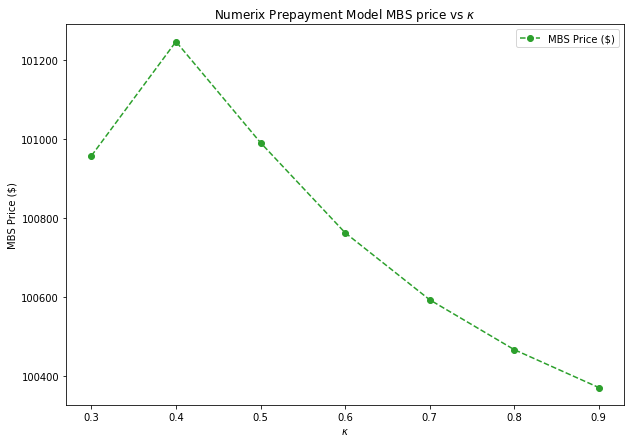

In [16]:
plt.figure(figsize=(10,7))
plt.plot(*zip(*MBS_ks_Numerix), 'C2', linestyle='--', 
         marker='o', label = 'MBS Price ($)')
plt.title("Numerix Prepayment Model MBS price vs $\kappa$")
plt.xlabel("$\kappa$")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()

When $\kappa$ = 0.3 the short term interest rate paths are more likely to stay far away from the long run mean (slow mean reversion). Since the standard deviation of the short term rate path is 0.12, there is a moderate probability of the paths staying below 0, which triggered the full trucation conditions of the CIR model. The full truncation of the interest rate paths then led to a non-symetrical scatter around the long-run mean, which could screw the mean upwards (larger than expected). The larger mean of the short interest rate paths caused an increase of discount factors, which resulted in lower valuation of the MBS at $\kappa$ = 0.3

**(c)** Compute the price of the MBS for the following ranges of the parameters: $\bar{r}$ in 0.03 to 0.09 (in increments of 0.01) and draw the graph of the price vs. $\bar{r}$.

**Solution:**

In [17]:
r_means = arange(0.03, 0.091, 0.01)
MBS_rs_Numerix = [(i, NumerixPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = i, sd = 0.12)) for i in r_means]

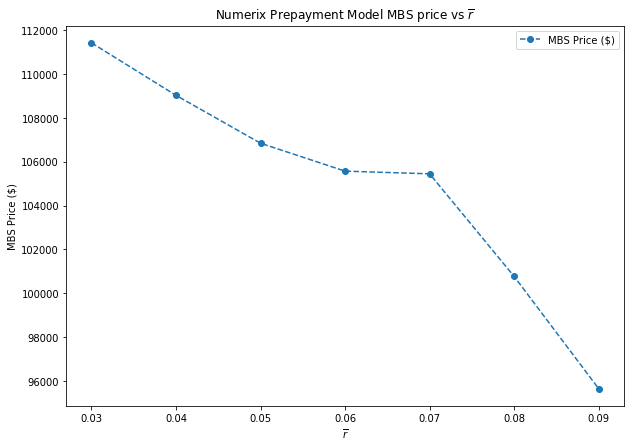

In [18]:
plt.figure(figsize=(10,7))
plt.plot(*zip(*MBS_rs_Numerix), 'C0', linestyle='--', 
         marker='o', label = 'MBS Price ($)')
plt.title("Numerix Prepayment Model MBS price vs $\overline{r}$")
plt.xlabel("$\overline{r}$")
plt.ylabel("MBS Price ($)")

plt.legend()
plt.show()

 **2.** Consider the PSA Model of prepayments.

**(a)** Compute the price of the MBS using the PSA model for Prepayments. The code should be generic: the user is prompted for inputs and the program runs and gives the output. 

**Solution:**

**PSA Model for CPR**

$CPR_t =   \begin{cases}
      CPR_{t -1} + 0.2\% & \text{for $t$ < 30 months}\\
      CPR_{t -1} & \text{for $t$ $\geq$ 30 months}
    \end{cases}$

In [19]:
def PSA_CPRt(t):
    CPRt = ((0.2/100) * t if t < 30 else 0.06)
    return CPRt

Find loan value

In [20]:
def PSAPrepayModel(PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV_previous = PV0
    ct = zeros((paths, N))
    
    # find discount factor
    dft = discount_factor(r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = spotRate_10yr(r0, sd, k, r_mean, total_years, paths)
     
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_PSA = PSA_CPRt(t)
        # find cash flow at t
        ct[:, t - 1] = cash_flow_t(t, total_years, PV_previous, r, N, CPRt_PSA)
        # find total principal payment
        TPPt = ct[:, t - 1] - PV_previous*r
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt
    
    mortage_value = mean(sum(dft*ct, axis = 1))
    
    return mortage_value

In [21]:
print("The price of the MBS using PSA Prepayment Model: $",
       round(PSAPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12), 5))

The price of the MBS using PSA Prepayment Model: $ 100843.69197


**(b)** Compute the price of the MBS for the following ranges of the parameters: $\kappa$ in 0.3 to
0.9 (in increments of 0.1) and draw the graph of the price vs. $\kappa$. 

**Solution:**

In [22]:
k = arange(0.3, 0.91, 0.1)
MBS_ks_PSA = [(i, PSAPrepayModel(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = i, r_mean = 0.08, sd = 0.12)) for i in k]

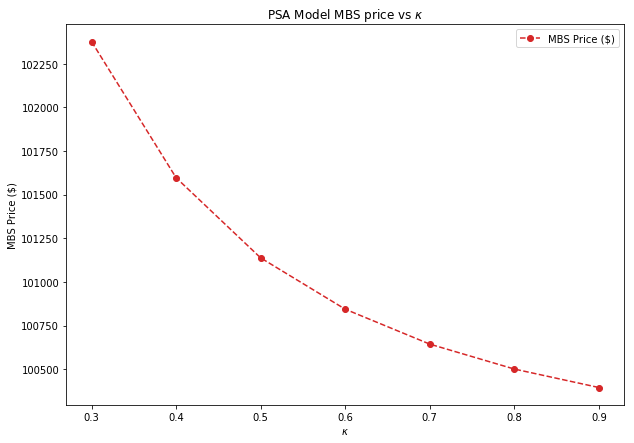

In [23]:
plt.figure(figsize=(10,7))
plt.plot(*zip(*MBS_ks_PSA), 'C3', linestyle='--', 
         marker='o', label = 'MBS Price ($)')
plt.title("PSA Model MBS price vs $\kappa$")
plt.xlabel("$\kappa$")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()

**3.** Compute the Option-Adjusted-Spread (OAS) for the Numerix-Prepayment model case with
the Market Price of MBS being $110,000.

**Solution:**

**Option Adjusted Spread (OAS) discount factor**

Adjust the discount factor and add in OAS as a parameter

In [24]:
def discount_factor_OAS(OAS, r0, sd, k, r_mean, total_years, paths):
    dt = 1/120
    ru = CIR(r0, sd, k, r_mean, total_years, paths)
    df = exp(-cumsum((ru + OAS)*dt , axis = 1))
    
    # choose time index that corresponds to the monthly payment
    pay_time = arange(1, total_years*12 + 1) * 10 - 1
    
    return df[:, pay_time]

**Option Adjusted Spread (OAS)**

Adjust the Numerix Prepayment Model function

In [25]:
def NumerixPrepayModel_OAS(OAS, PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV = zeros((paths, N))
    PV_previous = PV0
    ct = zeros((paths, N))
    
    # find discount factor
    dft = discount_factor_OAS(OAS, r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = spotRate_10yr(r0, sd, k, r_mean, total_years, paths)
     
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_numerix = Numerix_CPRt(t, WAC, r_10[:, t - 1], PV_previous, PV0)
        # find cash flow at t
        ct[:, t - 1] = cash_flow_t(t, total_years, PV_previous, r, N, CPRt_numerix)
        # find total principal payment
        TPPt = ct[:, t - 1] - PV_previous*r
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt
    
    mortage_value = mean(sum(dft*ct, axis = 1))
    
    return mortage_value

Optimizing function 

In [26]:
def f_opt(OAS, market_price):
    # price difference= model price - market price
    price_difference = NumerixPrepayModel_OAS(OAS = OAS, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12) - market_price
    return price_difference

Finding the OAS with Newton's Method

In [27]:
def find_OAS(market_price):
    # using Newton's method to find the OAS by finding the zero of the optimizing function
    OAS = newton(f_opt, 0, args = (market_price,), maxiter=100, tol=1e-50)
    return OAS

In [28]:
OAS_Numerix = find_OAS(market_price = 110000)
print("The option adjusted spread for Numerix Model : ", round(OAS_Numerix, 5))

The option adjusted spread for Numerix Model :  -0.01257


The negative OAS shows that the model underpriced the MBS relative to the market

**4.** Compute the OAS-adjusted Duration and Convexity of the MBS, considered in the previous question.


**Solution:**

Find the MBS price after pertubing 

In [29]:
def pertubPrice(OAS):

    # pertub OAS to respective prices
    dx = 5*(0.01/100)
    # P+, P-, P0
    P_up = NumerixPrepayModel_OAS(OAS = OAS + dx, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12)
    P_down = NumerixPrepayModel_OAS(OAS = OAS - dx, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12)
    P0 = NumerixPrepayModel_OAS(OAS = OAS, 
                                       PV0 = 100000, total_years = 30, WAC = 0.08, 
                                       r0 = 0.078, k = 0.6, r_mean = 0.08, sd = 0.12)
    return [P0, P_up, P_down]

$OAS-Duration = \frac{P_- - P_+}{2\Delta x \cdot P_0}$



In [30]:
def OAS_duration(P_up, P_down, P0):
    dx = 5*(0.01/100)
    duration = (P_down - P_up)/(2*dx*P0)
    
    return duration

$OAS-Convexity = \frac{P_- + P_+ - 2P_0}{2(\Delta x)^2 \cdot P_0}$

In [31]:
def OAS_convexity(P_up, P_down, P0):
    dx = 5*(0.01/100)
    convexity = (P_down + P_up - 2*P0)/(2 * (dx)**2 * P0)
    
    return convexity

In [32]:
P0, P_up, P_down = pertubPrice(OAS_Numerix)
durationOAS = OAS_duration(P_up, P_down, P0)
convexityOAS = OAS_convexity(P_up, P_down, P0)

In [33]:
print("The duration of option adjusted spread for Numerix Model : ", durationOAS)
print("The conexity of option adjusted spread for Numerix Model : ", convexityOAS)

The duration of option adjusted spread for Numerix Model :  7.21669733156
The conexity of option adjusted spread for Numerix Model :  45.7991160659


**5.** Consider the MBS described above and the IO and PO tranches. Use the NumerixPrepayment Model and price the IO and PO tranches for: $\bar{r}$ in 0.03 to 0.09 range, in increments of 0.01.

**Solution:**

For every cash flow at time t, break down the cash flow into IO and PO component

In [34]:
def Numerix_IO_PO(PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV_previous = array([PV0]*paths)
    ct = zeros((paths, N))
    
    # Initialize PO, IO portion of the MBS
    Interest = zeros((paths, N))
    Principal = zeros((paths, N))
    
    # find discount factor
    dft = discount_factor(r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = spotRate_10yr(r0, sd, k, r_mean, total_years, paths)
     
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_Numerix = Numerix_CPRt(t, WAC, r_10[:, t - 1], PV_previous, PV0)
        # find cash flow at t
        ct[:, t - 1] = cash_flow_t(t, total_years, PV_previous, r, N, CPRt_Numerix)
        # find total principal payment
        Interest[:, t - 1] = PV_previous*r
        TPPt = ct[:, t - 1] - PV_previous*r
        Principal[:, t - 1] =  TPPt
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt

   
    IO = mean(sum(dft*Interest, axis = 1))
    PO = mean(sum(dft*Principal, axis = 1))
    
    return [IO, PO]

Find IO portion of the MBS

In [35]:
r_means = arange(0.03, 0.091, 0.01)
IO = [(i, Numerix_IO_PO(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = i, sd = 0.12)[0]) for i in r_means]
pd.DataFrame(IO, columns=['long run mean (r)',  'Interest Only Price($)'])

,long run mean (r),Interest Only Price($)
0,0.03000,27208.53551
1,0.04000,26837.11926
2,0.05000,27201.25987
3,0.06000,33711.41875
4,0.07000,51131.33774
5,0.08000,53631.82606
6,0.09000,52449.65583


Find PO portion of the MBS

In [36]:
PO = [(i, Numerix_IO_PO(PV0 = 100000, total_years = 30, WAC = 0.08, 
                                r0 = 0.078, k = 0.6, r_mean = i, sd = 0.12)[1]) for i in r_means]
pd.DataFrame(PO, columns=['long run mean (r)',  'Principal Only Price($)'])

,long run mean (r),Principal Only Price($)
0,0.03000,84220.02753
1,0.04000,82192.99875
2,0.05000,79643.83463
3,0.06000,71860.32871
4,0.07000,54316.91533
5,0.08000,47131.51487
6,0.09000,43190.45736


Plot IO, PO portion vs. $\bar{r}$

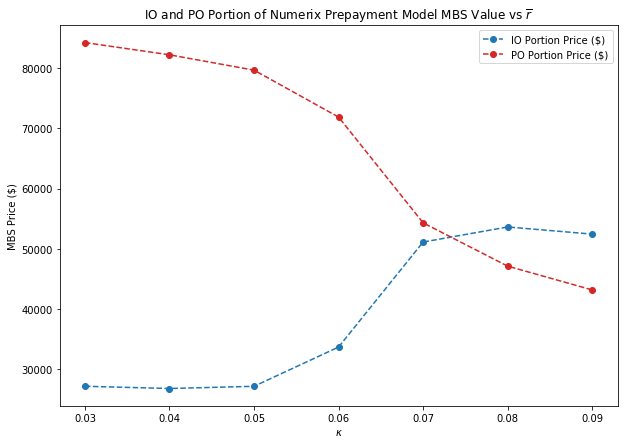

In [37]:
plt.figure(figsize=(10,7))
plt.plot(*zip(*IO), 'C0', linestyle='--', 
         marker='o', label = 'IO Portion Price ($)')
plt.plot(*zip(*PO), 'C3', linestyle='--', 
         marker='o', label = 'PO Portion Price ($)')

plt.title("IO and PO Portion of Numerix Prepayment Model MBS Value vs $\overline{r}$")
plt.xlabel("$\kappa$")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()